<a href="https://colab.research.google.com/github/jweir136/Using-Moving-Averages-1/blob/master/Using_MV_As_Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Moving Average as a Feature

The following notebook is an example of how to use the moving average as a feature in a time series problem.  This example uses the historic stock price of $XOM.

***Be sure to read the comments in the code.***

In [1]:
# Start by importing the required packages.
# also be sure to set matplotlib to inline so that it can be viewed in the notebook.

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Preparing the Data

These are the steps required before the features can be created and modeled.

In [0]:
# Add the data from the csv file. Be sure to parse the dates.

data = pd.read_csv("XOM.csv", parse_dates=['date'])

In [0]:
# Set the index of the DF to the dates. This helps for graphing, as the x-axis labels will be the dates.

data.set_index("date", drop=True, inplace=True)

In [0]:
"""
  Now we only want to use the close values for this tutorial. This is called a univariate time series problem.
  To do this, we are going to set the DF equal to the only column in the DF that we want to use, the closing prices.
"""

data = data['close']

In [5]:
# Now let's look at the new DF.

data.head(10)

date
2014-01-13    82.0299
2014-01-14    82.5043
2014-01-15    82.2213
2014-01-16    82.3545
2014-01-17    82.5376
2014-01-21    81.9883
2014-01-22    81.4722
2014-01-23    80.7147
2014-01-24    78.9501
2014-01-27    79.0084
Name: close, dtype: float64

In [0]:
"""
  Now looking at the data, we see a problem here.
  The frequency that the data is sampled isn't very constant.
  This is normal for stocks considering that the market isn't open every day.
  But this can cause problems for our model.
  To solve this, we are going to instead use the mean of every month as our data.
"""

data = data.resample("MS").mean()

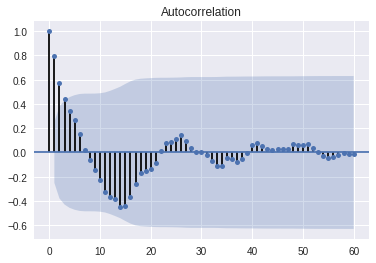

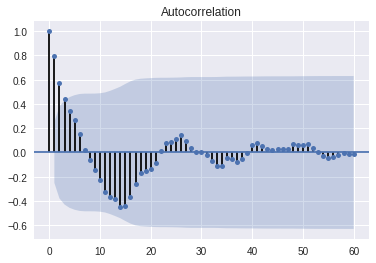

In [7]:
"""
  Now that we have our resampled data, we want to try to decide if this time series problem can even be solved this way.
  This is called autocorrelation. If there is a high autocorrelation, then that means that this problem is suitable for time series.
  To find the autocorrelation we can use `pd.autocorr()`, or if we want to graph it we can use the statsmodels `plot_acf` function.
"""

plot_acf(data)

By the looks of the plot, using lag variables from 1 to 3 may be significant.  However, anything past that.  So, we are going to use lag 1 since it had the highest correlation (zero does not count).
For more information on autocorrelation you can read up on it [here](https://en.wikipedia.org/wiki/Autocorrelation).

Now that we know that our autocorrelation is high enough to be able to predict using univariate time series, we want to remove any trend or seasonality in the data.  We will do this by differencing the data.


In [0]:
# Difference the data to remove any trend.

data = data - data.shift(1)

Now that we have removed the trend, we can create the moving average feature.  To start, we are going to create 2 copies of the data.  The first one will be the features, and the second one will be the y-values.

In [0]:
features = data.copy()
outputs = data.copy()

Now, in order to use MV as a feature, we first need to take the first copy of the data and shift it by 1.  This will be our features dataset.  It is important to shift it by one, since doing so ensures that we don't leak any data.  Next, we are going to take our output data, and shift it by the window that we intend to use for the rolling average minus 1.  So, since this example has a window of 3, we will want to shift our outputs by 3-1 = 2.  Lastly, we are going to take the rolling mean of the new outputs.

In [0]:
features = features.shift(1)

In [0]:
outputs = outputs.shift(2)

In [0]:
outputs = outputs.rolling(3).mean()

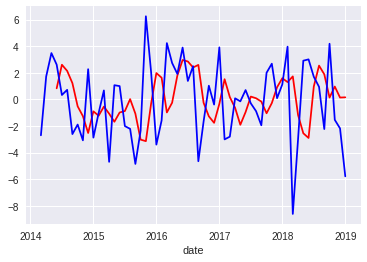

In [13]:
# Plot the features vs. the outputs.

outputs.plot(color='red')
features.plot(color='blue')

Now that we have created our features and outputs, we want to split our data into training and test sets.  Keep in mind that we have to keep our data in order, since in time series order is everything.

In [0]:
trainX = features[:round(len(features) * .75)]
testX = features[round(len(features) * .75):]
trainY = outputs[:round(len(outputs) * .75)]
testY = outputs[round(len(outputs) * .75):]

In [0]:
# Fill in any of the missing values.

trainX.fillna(method='backfill', inplace=True)
trainY.fillna(method='backfill', inplace=True)
testX.fillna(method='backfill', inplace=True)
testY.fillna(method='backfill', inplace=True)

Now from here we have created our features, we can move on creating and training a model.  For this example we are going to use Random Forest Regression.  Now, if this was not just an example for feature engineering, we would try and test a wide range of models in order to find the best one.

## Creating the Model

In [16]:
rf = RandomForestRegressor(n_jobs=-1).fit(trainX.values.reshape(-1, 1), trainY.values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [17]:
# Find the MSE.  We are going to square the data in order to find the actual difference between predicted and actual.
# Based on the MSE here, we are about 2 units off.  Compared to a mean of about -0.5, this is a lot.
# Now let's plot our predicted vs. actual in order to visualize how well our model is going.

np.sqrt(mean_squared_error(testY.values.reshape(-1, 1), rf.predict(testX.values.reshape(-1, 1))))

2.058459225904149

In [0]:
preds = rf.predict(testX.values.reshape(-1, 1))

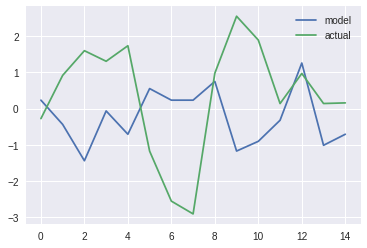

In [19]:
plt.plot([a for a in range(len(preds))], preds, label='model')
plt.plot([a for a in range(len(testX))], testY, label='actual')
plt.legend()

## The End